Non-commercial Use License

Copyright (c) 2021 Siemens Technology

This software, along with associated documentation files (the "Software"), is 
provided for the sole purpose of providing Proof of Concept. Any commercial 
uses of the Software including, but not limited to, the rights to sublicense, 
and/or sell copies of the Software are prohibited and are subject to a 
separate licensing agreement with Siemens. This software may be proprietary 
to Siemens and may be covered by patent and copyright laws. Processes 
controlled by the Software are patent pending.

The above copyright notice and this permission notice shall remain attached 
to the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE 
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc
# rc('text', usetex=True)
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

from PIL import Image, ImageSequence

# local application imports
from systems.bouncing_mass_points import BouncingMassPoints
from systems.bouncing_disks import BouncingDisks
from systems.chain_pendulum_with_contact import ChainPendulumWithContact
from systems.rope_chain import RopeChain
from systems.elastic_rope import ElasticRope
from systems.gyroscope_with_wall import GyroscopeWithWall

seed_everything(0)
%matplotlib inline
DPI = 600
FIG_DIR = os.path.join(THIS_DIR, "figures")

In [2]:
system_names = [
    "ER_default",
    "ER200k50"
]
model_names = [
    "CLNNwC_IP",
    "CHNNwC_IP",
    "CLNNwC_IPR",
    "CHNNwC_IPR",
]
short_system_names = [
    "Rope10",
    "Rope200"
]
formal_model_names = [
    "CM-CLNN",
    "CM-CHNN",
    "CMr-CLNN",
    "CMr-CHNN"
]

In [3]:
import pickle
logs = {}
for system in system_names:
    logs[system] = {}
    for model in model_names:
        with open(model+'_'+system, 'rb') as handle:
            logs[system][model] = pickle.load(handle)

In [4]:
# the bodies here are used to make sure correct dimensions in Animation. is_mujoco or not does not matter
import json
bodies = {}
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

class_names = [
    "ElasticRope",
    "ElasticRope",
]
for i in range(2):
    with open(os.path.join(PARENT_DIR, "examples", system_names[i] +".json"), "r") as file:
        body_kwargs = json.load(file)
    bodies[system_names[i]] = str_to_class(class_names[i])(system_names[i], **body_kwargs)


In [5]:
# c_palette = ['#fdae6b', '#e6550d', '#9ecae1', '#3182bd', '#cbc9e2', '#9e9ac8', '#6a51a3']
c_palette = ['#fdae6b', '#e6550d', '#9ecae1', '#3182bd']

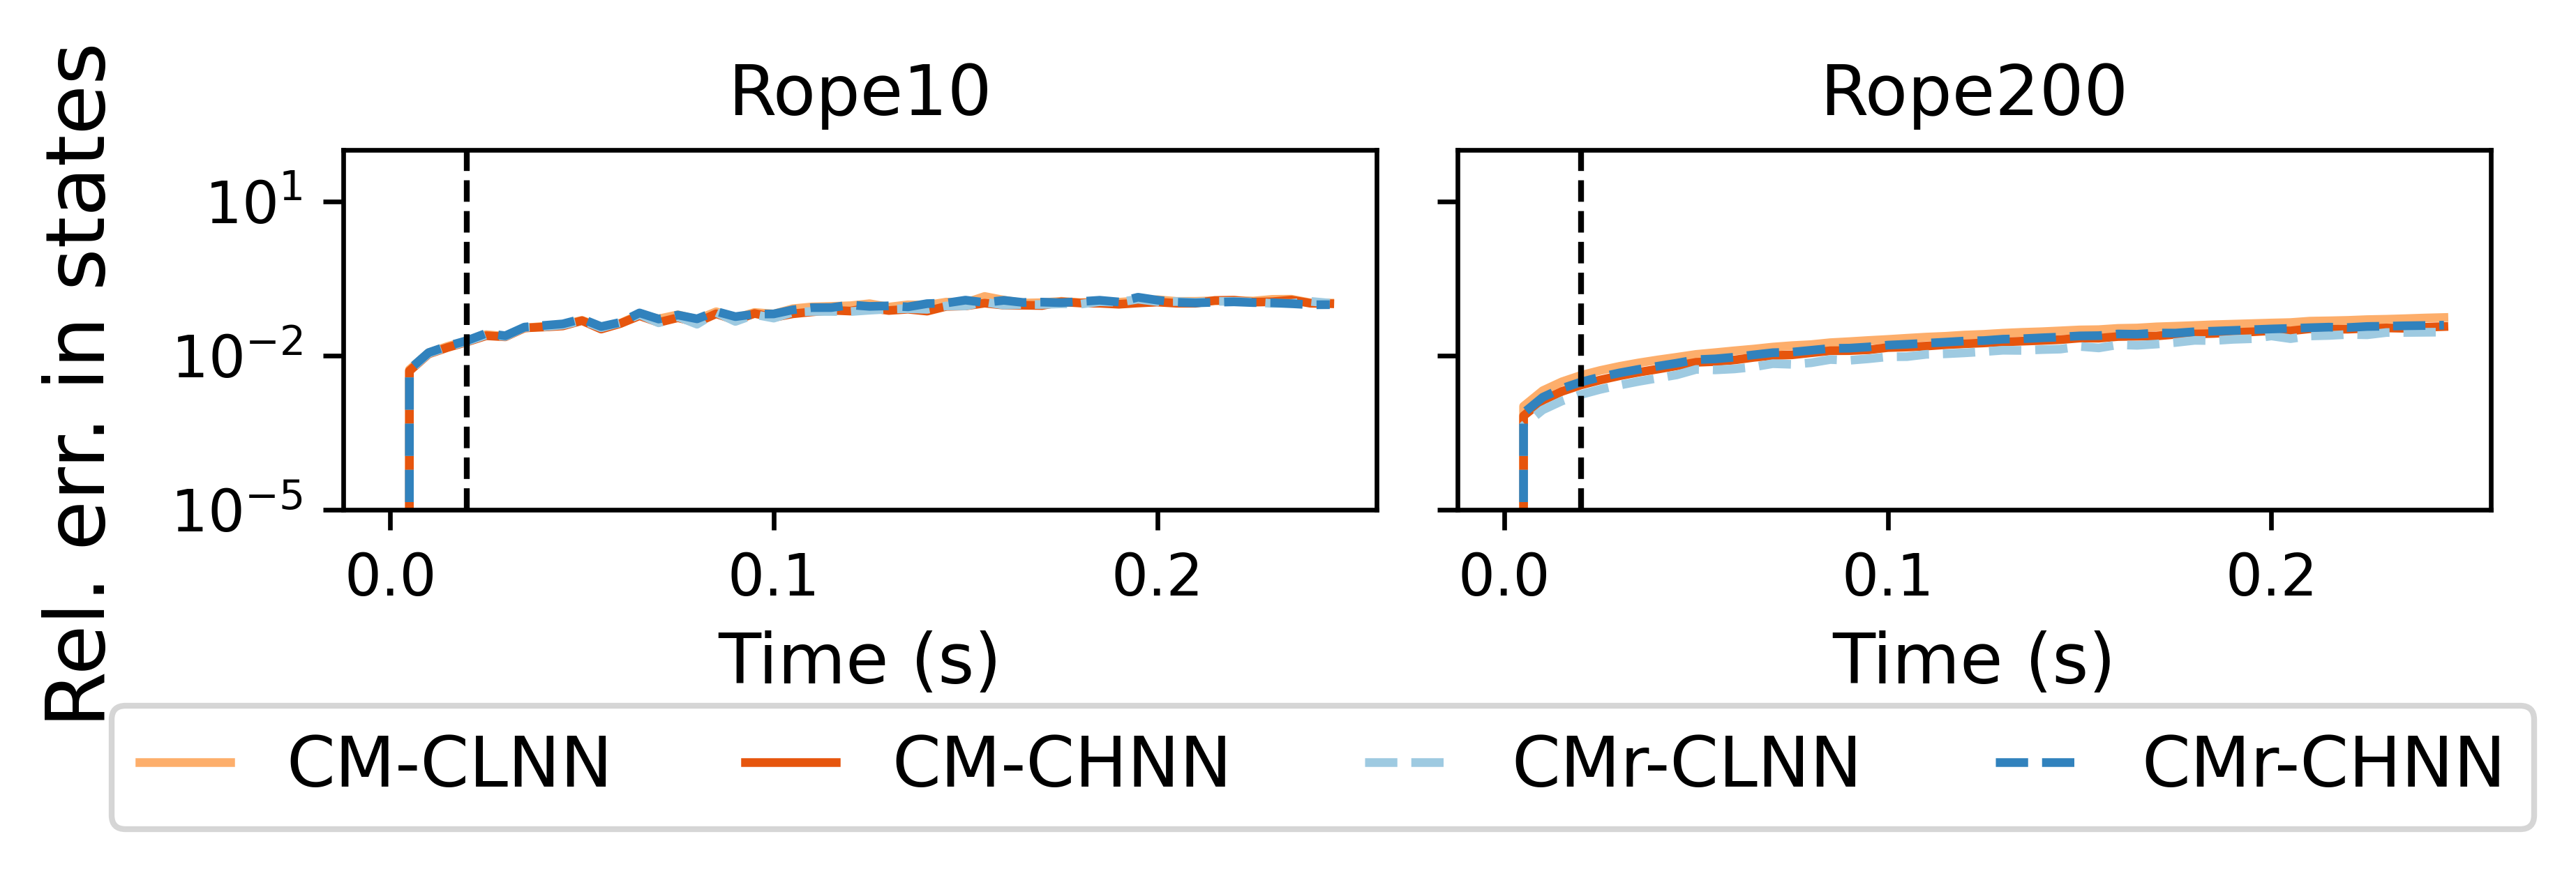

In [22]:
# plot rel err over time
metric = 'rel_err' ; s = 0; e = 50 ; l1 = 1e-5 ; l2 = 1e2
t1 = np.arange(s, e) * 0.01
t2 = np.arange(s, e) * 0.02
t3 = np.arange(s, e) * 0.005
ts = [t3, t3]
fig,ax = plt.subplots(1,2,sharey=True,figsize=(6, 2.0), dpi=DPI)
# fig = plt.figure(figsize=(12, 3.2), dpi=DPI)
for y_id in range(2):
    i = y_id
    for j in range(len(model_names)):
        if j < 2:
            ls = "solid"
        else:
            ls = "dashed"
        ax[y_id].plot(ts[i], logs[system_names[i]][model_names[j]][metric].numpy().mean(0)[s:e], color=c_palette[j], linewidth=1.5, linestyle=ls, label=formal_model_names[j])
    ax[y_id].axvline(4*ts[i][1], 0, 1, color='k', linestyle="--", linewidth=1)
    ax[y_id].set_yscale('log')
    ax[y_id].set_ylim(l1, l2)
    ax[y_id].set_title(short_system_names[i])

    ax[y_id].set_xlabel('Time (s)', fontsize=12)
plt.tight_layout()
_, labels = ax[0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.39, left=0.12)
fig.text(0.00, 0.54, 'Rel. err. in states', va='center', rotation='vertical', fontsize=14)
fig.legend(labels=labels, 
           bbox_to_anchor=(0.025, 0., 0.970, 0.), 
           loc="lower center", 
           ncol=len(labels), 
           borderaxespad=0.1, 
           handlelength=1.3,
           mode="expand", fontsize=12)
# fig.savefig(os.path.join(FIG_DIR, 'RSS_rel_err.pdf'), bbox_inches='tight')

In [7]:
imgs = {}

In [6]:
def get_frames(imgs, system_name, traj_id):
    imgs[system_name] = {}
    imgs[system_name]['true'] = []
    ani = bodies[system_name].animate(logs[system_name][model_names[0]]['true_zts'][traj_id])
    ani.save(os.path.join(THIS_DIR, 'temp', 'temp.gif'), writer='pillow')
    img = Image.open(os.path.join(THIS_DIR, 'temp', 'temp.gif'))
    frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
    imgs[system_name]['true'] = frames


    for model_name in model_names:
        imgs[system_name][model_name] = []
        ani = bodies[system_name].animate(logs[system_name][model_name]['pred_zts'][traj_id])
        ani.save(os.path.join(THIS_DIR, 'temp', 'temp.gif'), writer='pillow')
        img = Image.open(os.path.join(THIS_DIR, 'temp', 'temp.gif'))
        frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
        imgs[system_name][model_name] = frames

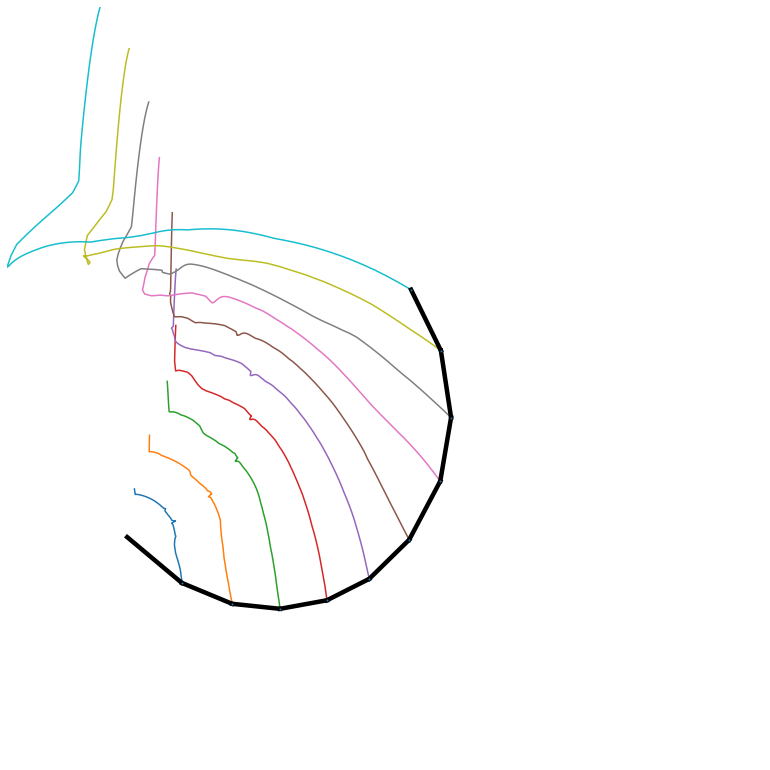

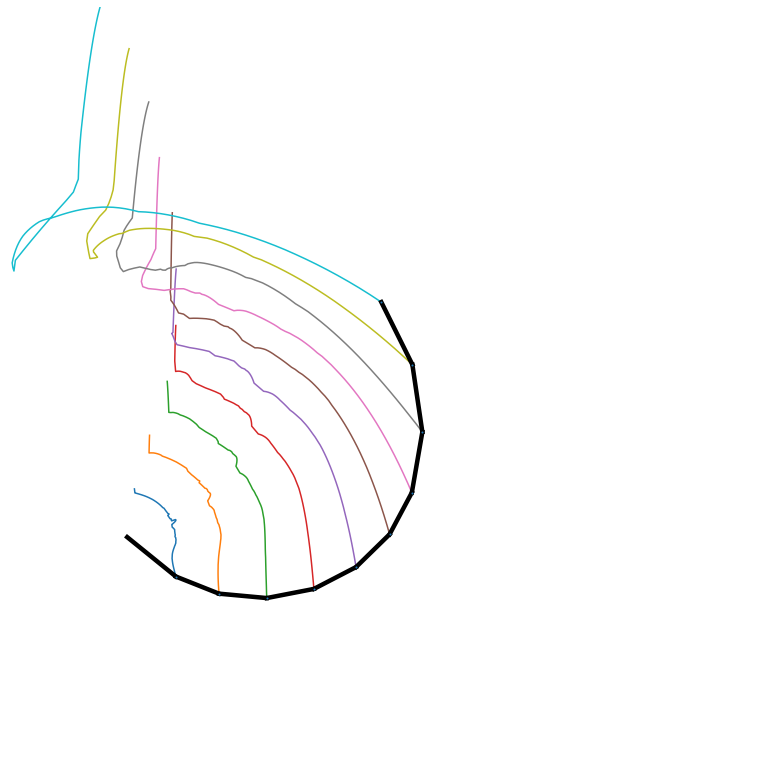

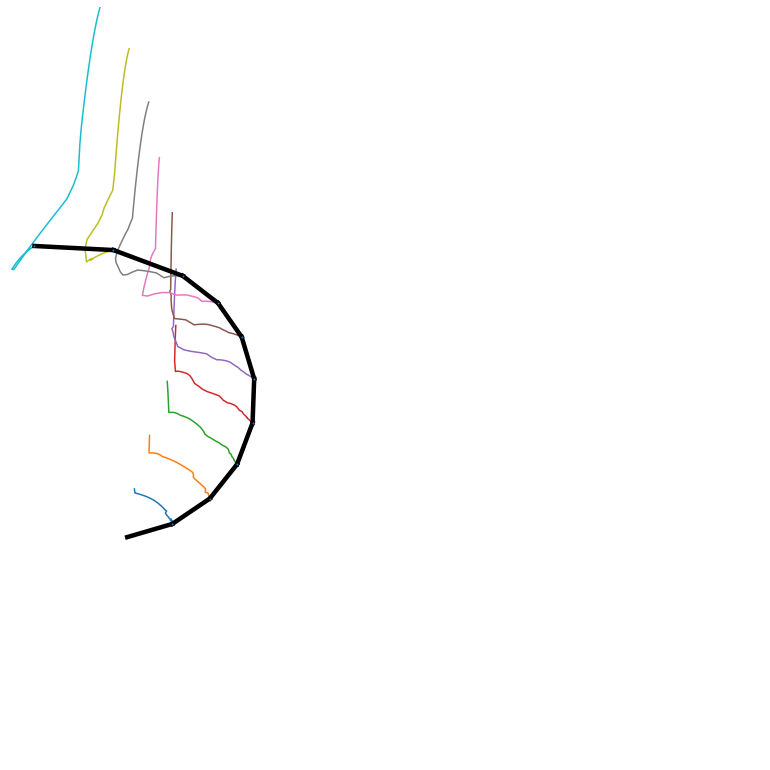

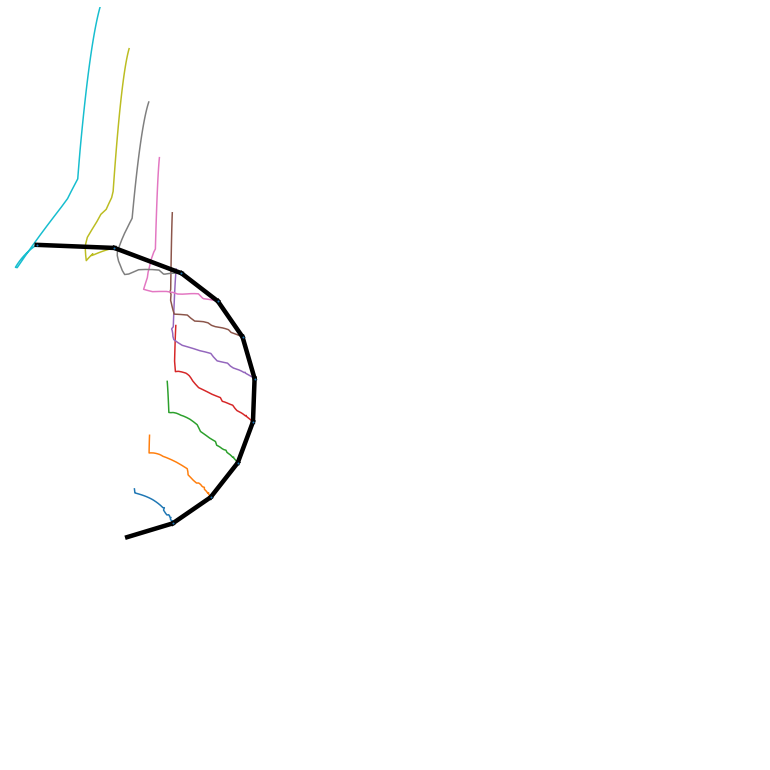

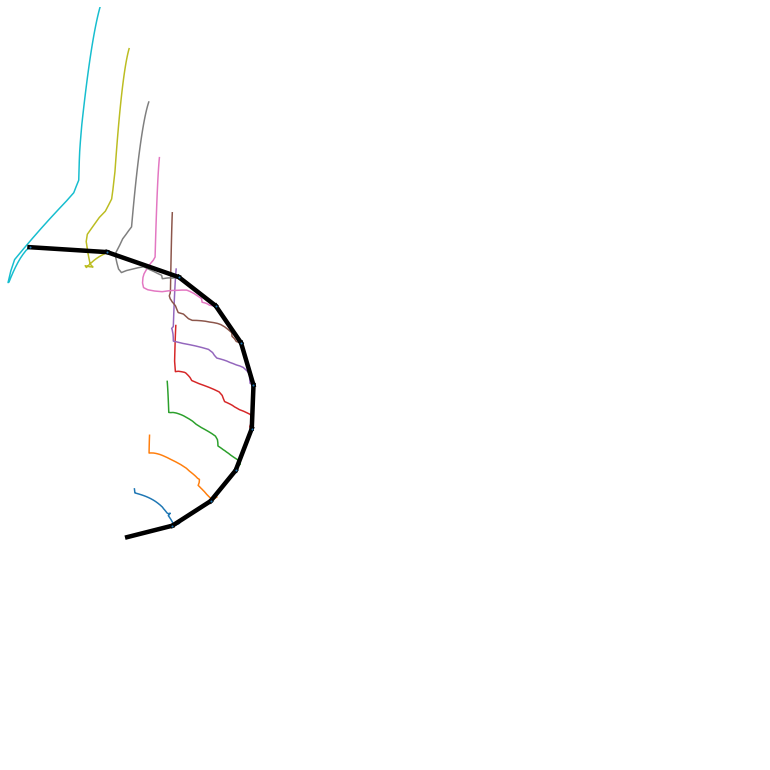

In [8]:
get_frames(imgs, system_names[0], 0)

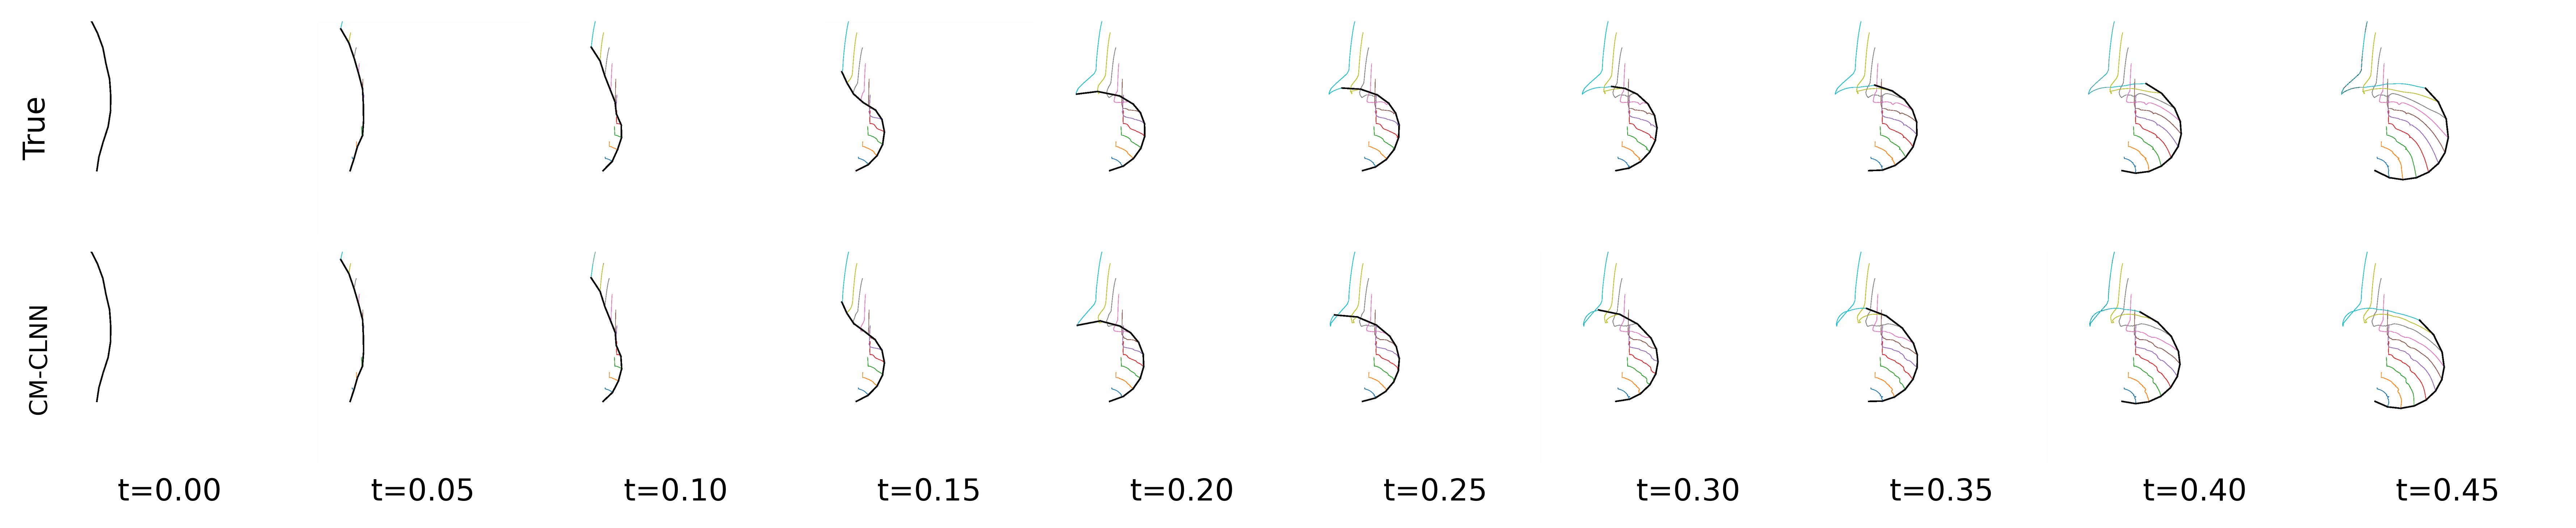

In [10]:
## plot snapshot
system_name = system_names[0]
fig = plt.figure(figsize=(12, 2.5), dpi=DPI)
for j in range(2):
    for i in range(10):
        idx = j*10 + i + 1
        ax = plt.subplot(2, 10, idx)
        # remove border
        plt.setp(ax.spines.values(), visible=False)
        # remove ticks and labels
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        # add labels
        if i == 0:
            if j == 0:
                ax.set_ylabel("True")
            else:
                ax.set_ylabel(formal_model_names[j-1], fontsize=8)
        if j == 1:
            ax.set_xlabel(f't={i*0.005*10:.2f}')
        # plot 
        try:
            if j == 0:
                ax.imshow(imgs[system_name]['true'][i*10])
            else:
                ax.imshow(imgs[system_name][model_names[j-1]][i*10])
        except:
            continue

# https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots
# line = plt.Line2D([0,1],[0.87,0.87], transform=fig.transFigure, color="black")
# fig.add_artist(line)
# line = plt.Line2D([0,1],[0.39,0.39], transform=fig.transFigure, color="black", linestyle='--')
# fig.add_artist(line)
plt.tight_layout()

# fig.savefig(os.path.join(FIG_DIR, 'RSS_pred_seq_Rope10.pdf'), bbox_inches='tight')

### Mass Ratio

In [15]:
from trainer import Model
mass_10 = {}
mass_200 = {}

In [16]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER200k50_CLNNwC_N800",
    "version_2",
    # "epoch=13.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_200[formal_model_names[0]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

800 out of 800 trajectories contains collision.
100 out of 100 trajectories contains collision.
100 out of 100 trajectories contains collision.


In [17]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER200k50_CHNNwC_N800",
    "version_2",
    # "epoch=14.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_200[formal_model_names[1]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

800 out of 800 trajectories contains collision.
100 out of 100 trajectories contains collision.
100 out of 100 trajectories contains collision.


In [18]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER200k50_mujoco_CLNNwC_N800",
    "version_2",
    # "epoch=9.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_200[formal_model_names[2]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

800 out of 800 trajectories contains collision.
100 out of 100 trajectories contains collision.
100 out of 100 trajectories contains collision.


In [19]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER200k50_mujoco_CHNNwC_N800",
    "version_2",
    # "epoch=8.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_200[formal_model_names[3]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

800 out of 800 trajectories contains collision.
100 out of 100 trajectories contains collision.
100 out of 100 trajectories contains collision.


In [20]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER_default_CLNNwC_N800",
    "version_3",
    # "epoch=13.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_10[formal_model_names[0]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

512 out of 800 trajectories contains collision.
65 out of 100 trajectories contains collision.
65 out of 100 trajectories contains collision.


In [21]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER_default_CHNNwC_N800",
    "version_2",
    # "epoch=14.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_10[formal_model_names[1]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

512 out of 800 trajectories contains collision.
65 out of 100 trajectories contains collision.
65 out of 100 trajectories contains collision.


In [22]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER_default_mujoco_CLNNwC_N800",
    "version_2",
    # "epoch=9.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_10[formal_model_names[2]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

512 out of 800 trajectories contains collision.
65 out of 100 trajectories contains collision.
65 out of 100 trajectories contains collision.


In [23]:
checkpoint_path = os.path.join(
    PARENT_DIR,
    "logs",
    "ER_default_mujoco_CHNNwC_N800",
    "version_2",
    # "epoch=8.ckpt"
    "last.ckpt"
) 
model = Model.load_from_checkpoint(checkpoint_path)
learned_mass = torch.exp(model.model.m_params["0"])
mass_10[formal_model_names[3]] = (learned_mass / learned_mass[0]).detach().cpu().numpy()

512 out of 800 trajectories contains collision.
65 out of 100 trajectories contains collision.
65 out of 100 trajectories contains collision.


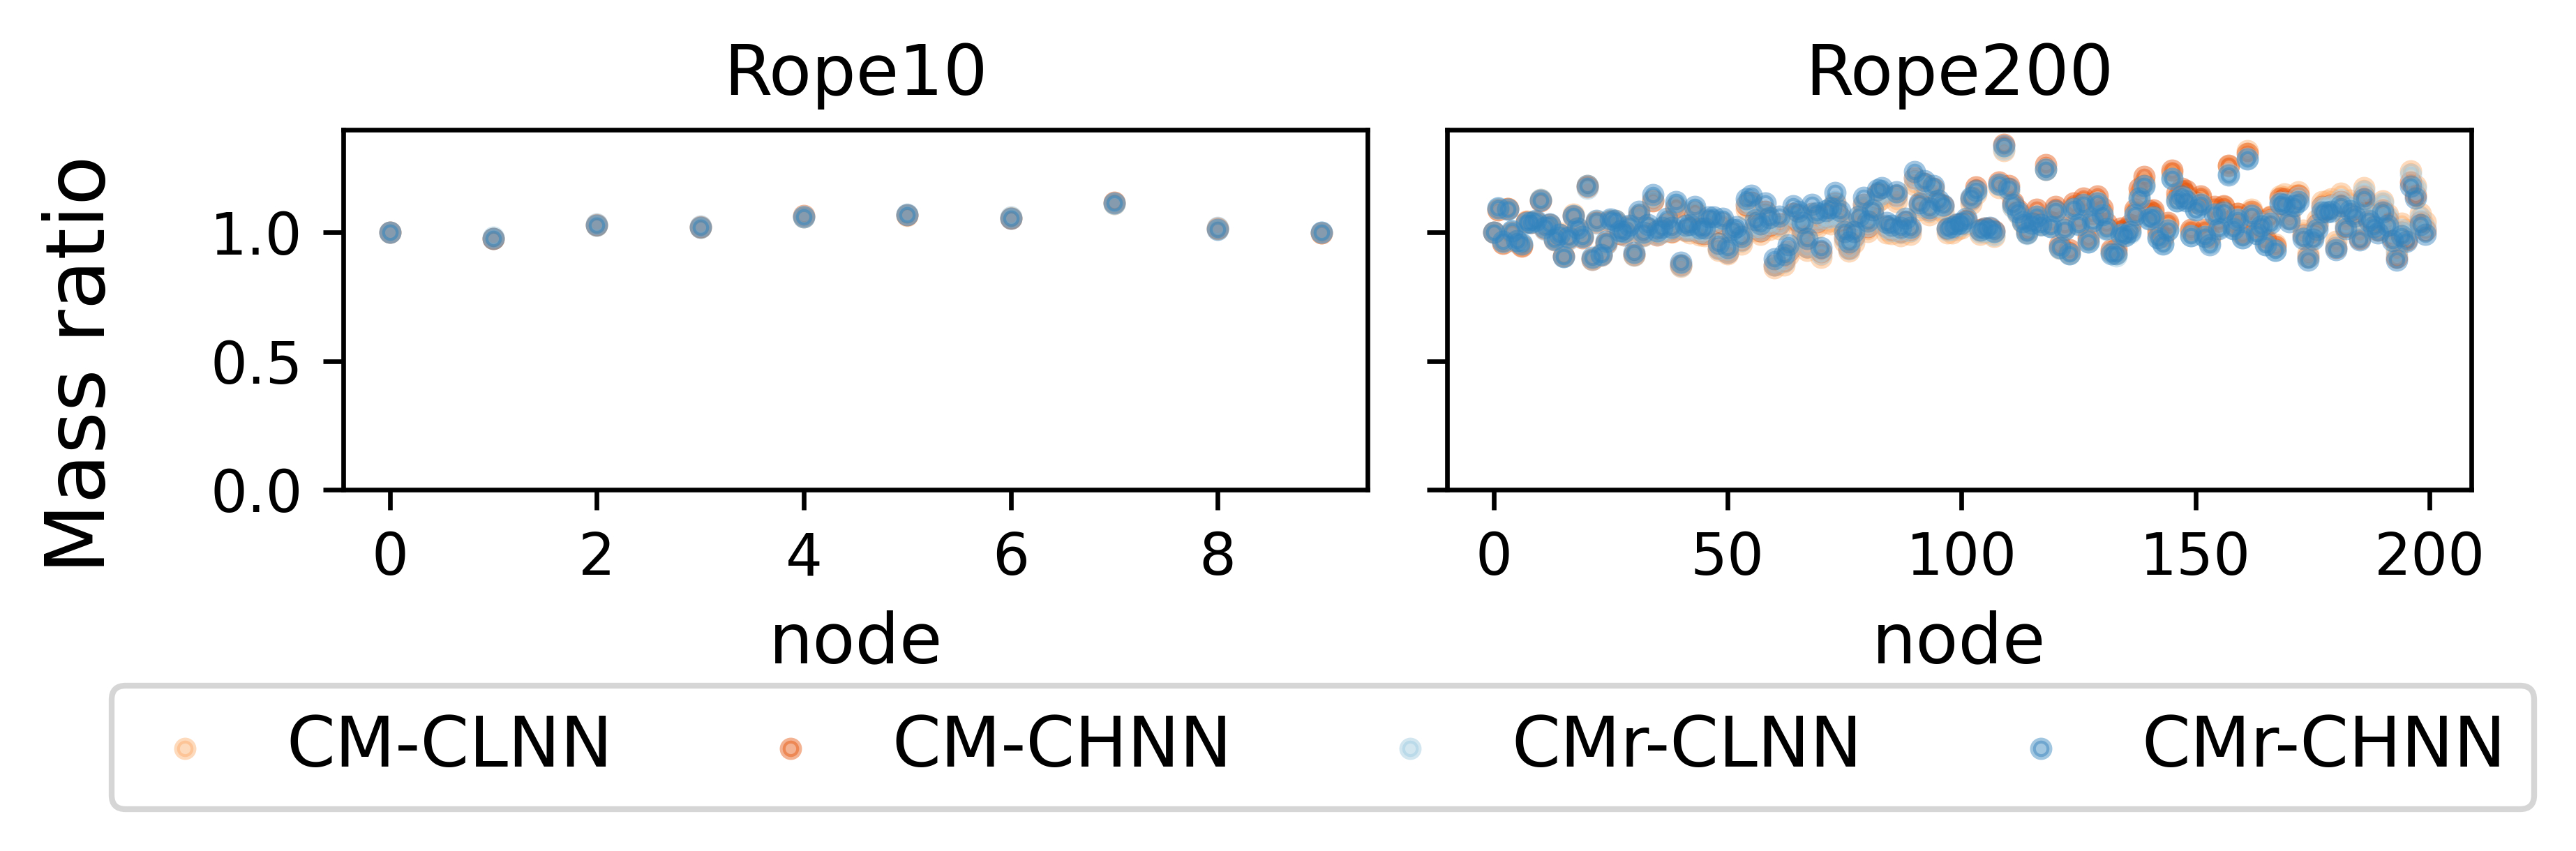

In [38]:
# plot rel err over time
metric = 'rel_err' ; s = 0; e = 50 ; l1 = 0 ; l2 = 1.4
t1 = np.arange(10)
t2 = np.arange(200)
ts = [t1, t2]
fig,ax = plt.subplots(1,2,sharey=True,figsize=(6, 2.0), dpi=DPI)
# fig = plt.figure(figsize=(12, 3.2), dpi=DPI)
for y_id in range(2):
    i = y_id
    for j in range(len(model_names)):
        if j < 2:
            ls = "solid"
        else:
            ls = "dashed"
        if i == 0:
            ax[y_id].scatter(ts[i], mass_10[formal_model_names[j]], s=8, alpha=0.45, color=c_palette[j], label=formal_model_names[j])
        else:
            ax[y_id].scatter(ts[i], mass_200[formal_model_names[j]], s=8, alpha=0.45, color=c_palette[j], label=formal_model_names[j])
#     ax[y_id].axvline(4*ts[i][1], 0, 1, color='k', linestyle="--", linewidth=1)
#     ax[y_id].set_yscale('log')
    ax[y_id].set_ylim(l1, l2)
    ax[y_id].set_title(short_system_names[i])

    ax[y_id].set_xlabel('node', fontsize=12)
plt.tight_layout()
_, labels = ax[0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.39, left=0.12)
fig.text(0.00, 0.54, 'Mass ratio', va='center', rotation='vertical', fontsize=14)
fig.legend(labels=labels, 
           bbox_to_anchor=(0.025, 0., 0.970, 0.), 
           loc="lower center", 
           ncol=len(labels), 
           borderaxespad=0.1, 
           handlelength=1.3,
           mode="expand", fontsize=12)
fig.savefig(os.path.join(FIG_DIR, 'RSS_mass_ratio.pdf'), bbox_inches='tight')